In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

In [2]:
train_dir = './chest_xray/train'
test_dir = './chest_xray/test'
val_dir = './chest_xray/val'

In [3]:
transform = transforms.Compose([
    transforms.Resize((180, 180)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)
val_data = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
val_loader = DataLoader(val_data, batch_size=1, shuffle=False)


In [4]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 22 * 22, 128)
        self.fc2 = nn.Linear(128, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 22 * 22)  # Flatten the layer
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x.view(-1)


model = MyModel()

In [5]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses, val_losses = [], []
train_acc, val_acc = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in val_loader:
        outputs = model(images)
        print("Outputs shape:", outputs.shape)
        print("Labels shape:", labels.shape)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = outputs.squeeze().round()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_acc.append(100 * correct / total)

    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels.float())
            val_loss += loss.item()
            predicted = outputs.squeeze().round()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_acc.append(100 * correct / total)

    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}%, Val Acc: {val_acc[-1]:.2f}%')


Outputs shape: torch.Size([1])
Labels shape: torch.Size([1])
Outputs shape: torch.Size([1])
Labels shape: torch.Size([1])
Outputs shape: torch.Size([1])
Labels shape: torch.Size([1])
Outputs shape: torch.Size([1])
Labels shape: torch.Size([1])
Outputs shape: torch.Size([1])
Labels shape: torch.Size([1])
Outputs shape: torch.Size([1])
Labels shape: torch.Size([1])
Outputs shape: torch.Size([1])
Labels shape: torch.Size([1])
Outputs shape: torch.Size([1])
Labels shape: torch.Size([1])
Outputs shape: torch.Size([1])
Labels shape: torch.Size([1])
Outputs shape: torch.Size([1])
Labels shape: torch.Size([1])
Outputs shape: torch.Size([1])
Labels shape: torch.Size([1])
Outputs shape: torch.Size([1])
Labels shape: torch.Size([1])
Outputs shape: torch.Size([1])
Labels shape: torch.Size([1])
Outputs shape: torch.Size([1])
Labels shape: torch.Size([1])
Outputs shape: torch.Size([1])
Labels shape: torch.Size([1])
Outputs shape: torch.Size([1])
Labels shape: torch.Size([1])
Epoch 1/10 - Train Loss:

Test Loss: 62.5000, Test Accuracy: 37.50%


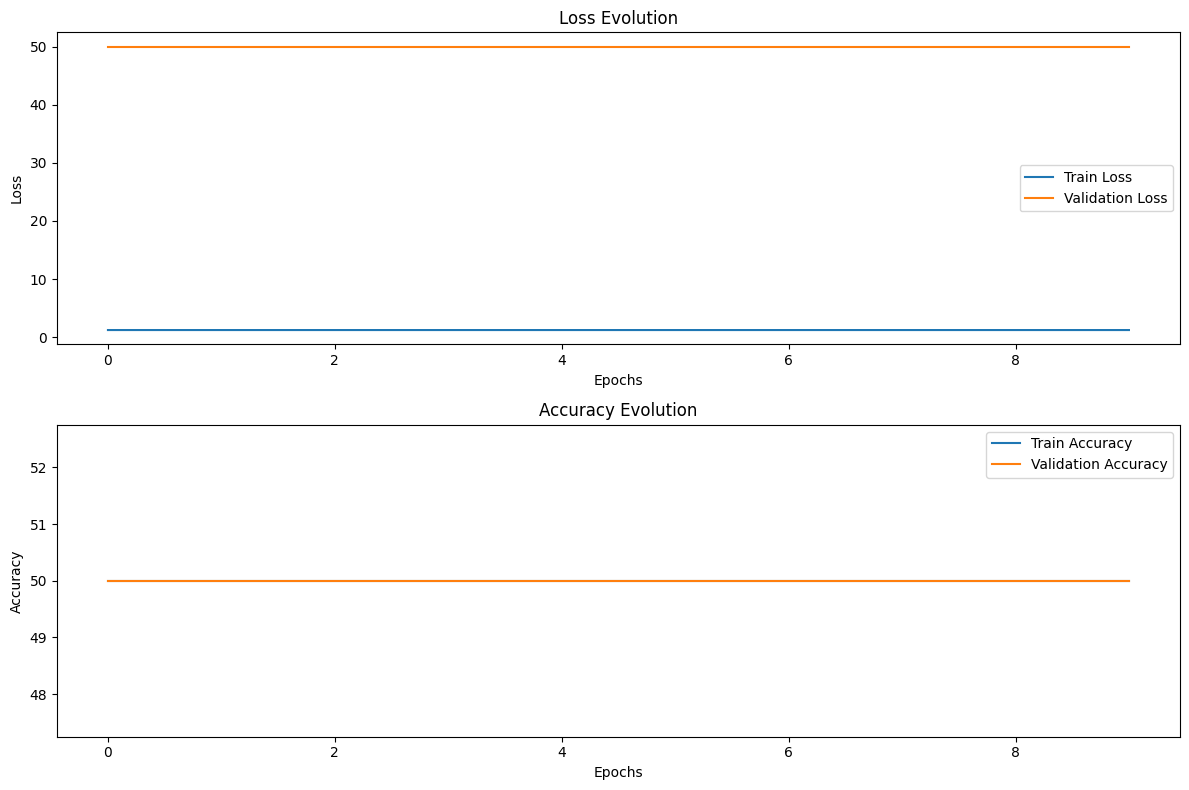

In [8]:
model.eval()
test_loss = 0.0
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        # Usa .squeeze(1) para eliminar específicamente la dimensión en la posición 1
        loss = criterion(outputs, labels.float())
        test_loss += loss.item()
        predicted = outputs.round()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Visualización de las métricas
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
